## Image preparation for a convolutional neural network with TensorFlow's Keras API 

In this episode, we'll go through all the necessary image preparation and processing steps to get set up to train our first convolutional neural network (CNN).

Our goal over the next few episodes will be to build and train a CNN that can accurately identify images of cats and dogs.

### Obtain the data

The first thing we need to do is get and prepare the data for which we'll be training the CNN.

The data set we'll use is a random subset of the data set from the Kaggle Dogs Versus Cats competition. You can download the data [here] https://www.kaggle.com/c/dogs-vs-cats/data.

### Organize the data

We now need to organize the directory structure on disk to hold the data set. We'll manually do some parts of the organization, and programmatically do the rest.

Copy the downloaded **dogs-vs-cats.zip** file, and paste it into whichever directory you'd like to work from. Relative to the Jupyter notebook we'll be working in, I'm placing **dogs-vs-cats.zip** within a directory called **dataset**.

Now, extract **dogs-vs-cats.zip**, and then extract **train.zip** from within. We won't be working with the provided **test** set for the moment, so you can move the **test1.zip** elsewhere if you'd like.

Next, select all of the image files from within the **train** directory and move them into the base dogs-vs-cats directory. Lastly, delete the empty train directory.

That's it for the manual labor! At this point, we have 25,000 labeled images of cats and dogs in our dogs-vs-cats directory. Note, the labels are included in the file names. Now, we'll do the remainder of the data organization programmatically.

First let's import all the libraries we'll be making use of over the next several CNN episodes. 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

Using the script below, we'll organize our data into train, validation, and test sets. We'll do this by moving subsets of the data into sub-directories for each separate data set. 

In [8]:
# Organize data into train, valid, test dirs
os.chdir('C:/Users/sumit/OneDrive/Escritorio/Universidad/Keras with Tensorflow/Dataset/dogs-vs-cats')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    
    for i in random.sample(glob.glob('cat*'), 500):
        shutil.move(i, 'train/cat')      
    for i in random.sample(glob.glob('dog*'), 500):
        shutil.move(i, 'train/dog')
    for i in random.sample(glob.glob('cat*'), 100):
        shutil.move(i, 'valid/cat')        
    for i in random.sample(glob.glob('dog*'), 100):
        shutil.move(i, 'valid/dog')
    for i in random.sample(glob.glob('cat*'), 50):
        shutil.move(i, 'test/cat')      
    for i in random.sample(glob.glob('dog*'), 50):
        shutil.move(i, 'test/dog')

os.chdir('../../')

We first check to see if the directory structure is already in place. If it's not, we proceed with the script. The script first makes train, valid, and test directories, which each contain sub-directories called dog and cat.

The full data set contains 25,000 images, half of which are cats, and half are dogs. We don't need nearly this much data for the tasks we'll be carrying out, so we're going to work with a subset. The remainder of the script moves 1000 samples into the training set, 200 samples into the validation set, and 100 samples into the test set. Each set has have an equal amount of cats and dogs.

The remainder of the unused data will remain in the base dogs-vs-cats directory. Feel free to remove this data if you'd like.

####  Scenario of not having test labels

Note, for this data set, we already have labels for the test set. Many times, we may not have corresponding labels for the test data. In fact, if we used the downloaded test set from Kaggle, rather than making our own, then we would see that the corresponding labels are not included.

In the scenario when we don't have labels for the test set, the test directory structure should instead look like this:

**test\unknown\**

All unlabeled test files will go into the unknown sub-directory. Note that you can name the directory something other than unknown if you prefer.

There is one additional step that needs to be done differently if you do not have access to the test labels, which is mentioned at the end of the next section below.

This is it for all the data organization on disk. Now let's check out the data processing that needs to be done before we can pass this data to the network. 

###  Process the data

We've already imported all the TensorFlow and Keras modules above. If you're using a GPU (not required), then we can check to be sure that TensorFlow is able to identify the GPU using the code below. It's also useful to enable memory growth on the GPU for reasons we covered in a previous episode.

We then create variables for which the the paths to the ***train, valid, and test*** data directories are assigned. 

In [9]:
train_path = 'C:/Users/sumit/OneDrive/Escritorio/Universidad/Keras with Tensorflow/Dataset/dogs-vs-cats/train'
valid_path = 'C:/Users/sumit/OneDrive/Escritorio/Universidad/Keras with Tensorflow/Dataset/dogs-vs-cats/valid'
test_path = 'C:/Users/sumit/OneDrive/Escritorio/Universidad/Keras with Tensorflow/Dataset/dogs-vs-cats/test'

We can either specify an absolute path or a relative path relative to where our Jupyter notebook resides. I'm specifying the absolute path.

Now, we use **Keras' ImageDataGenerator class** to create batches of data from the train, valid, and test directories.

**ImageDataGenerator.flow_from_directory()** creates a **DirectoryIterator**, which generates batches of normalized tensor image data from the respective data directories.

Notice, to **ImageDataGenerator** for each of the data sets, we specify **preprocessing_function=tf.keras.applications.vgg16.preprocess_input**. For now, just understand this does an additional processing step on the images. We'll cover what exactly this processing is when we work with the pre-trained VGG16 CNN in a future episode.

To **flow_from_directory()**, we first specify the path for the data. We then specify the target_size of the images, which will resize all images to the specified size. The size we specify here is determined by the input size that the neural network expects.

The classes parameter expects a list that contains the underlying class names, and lastly, we specify the batch_size.

We also specify **shuffle=False** only for test_batches. That's because, later when we plot the evaluation results from the model to a confusion matrix, we'll need to able to access the unshuffled labels for the test set. By default, the data sets are shuffled.

Note, in the case where you do not know the labels for the test data, you will need to modify the test_batches variable. Specifically, the change will be to set the parameters classes = None and class_mode = None in flow_from_directory(). 

In [10]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


###  Visualize the data

We now call **next(train_batches)** to generate a batch of images and labels from the training set. Note that the size of this batch is determined by the batch_size we set when we created train_batches. 

In [11]:
imgs, labels = next(train_batches)

We then use this plotting function obtained from TensorFlow's documentation to plot the processed images within our Jupyter notebook. 

In [12]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

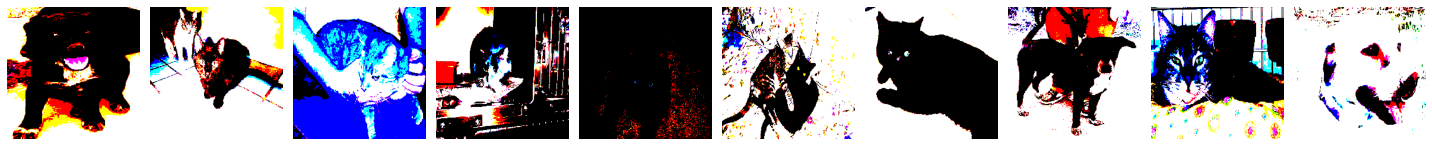

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [13]:
plotImages(imgs)
print(labels)

This is what the first processed random batch from the training set looks like. Notice that the color appears to be distorted. This has to do with the VGG16 processing we applied to the data sets, which we'll talk about in an upcoming episode. Don't worry about it for now, just know that the RGB pixel data has been processed in such a way that the image data now looks like this before being passed to the network.

Note that dogs are represented with the one-hot encoding of [0,1], and cats are represented by [1,0].

We're now all set up to work with this data! In the upcoming episodes, we'll use this data to train a convolutional neural network. 